In [56]:
import math
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy.integrate import quad_vec as scipy_integrate_quad_vec

from plotting import *

# Finite Element Method (FEM)
Weak formulation: $\underline{\underline{K}} \, \underline{u} = \underline{f}$

## Example (1D)

### Problem

![FEM_1D](FEM_1D.jpg)

Material properties

In [57]:
E = 200e9

Geometric properties: Length and cross sectional area of beam

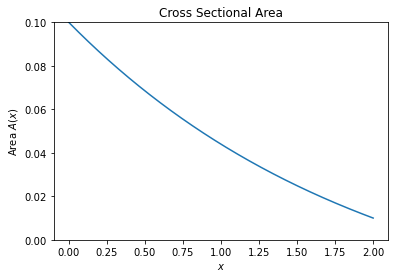

In [58]:
l = 2

# Exponential relation
A_0 = 100e-3
A_1 = 10e-3
A = lambda x: (A_0 - A_1)/(1-1/math.e) * np.exp(-x/l) + (A_1 - A_0*1/math.e)/(1-1/math.e)
plot_cross_section_area(A, l)

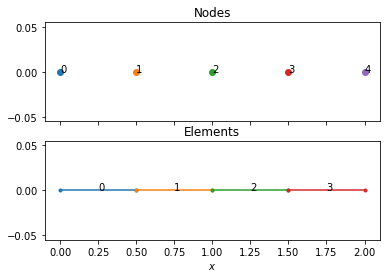

In [59]:
n_nodes = 5

n_elements = n_nodes - 1

node_list = np.linspace(0,l,n_nodes)
element_list = [[i, i+1] for i in range(n_nodes - 1)]

plot_1D_mesh(node_list, element_list)

Neumann boundary conditions

In [60]:
f = np.empty(np.shape(node_list))
f[:] = np.nan
f[1:-1] = 0  # important!
f[-1] = 100
print(f)

[ nan   0.   0.   0. 100.]


Diritchlet boundary conditions

In [61]:
u = np.empty(np.shape(node_list))
u[:] = np.nan
u[0] = 0
print(u)

[ 0. nan nan nan nan]


### Solving

Shape function

$\underline{ u}^{(e)} \approx a_0 + a_1 \cdot x$
<br/>
$\underline{ u}^{(e)} \approx \underline{ \underline{ N}}^{(e)} \underline{ u}^{(e)}= \underline{ \underline{ N_1}}^{(e)} \underline{ u_1}^{(e)} + \underline{ \underline{ N_2}}^{(e)} \underline{ u_2}^{(e)}$

In [62]:
# General element independent form
x = sym.Symbol("x")
a_0 = sym.Symbol("a_0")
a_1 = sym.Symbol("a_1")

u_e = a_0  + a_1 * x

x_1_e = sym.Symbol("x_1_e")
x_2_e = sym.Symbol("x_2_e")
u_1_e = sym.Symbol("u_1_e")
u_2_e = sym.Symbol("u_2_e")

sol = sym.solve([u_e.subs("x", x_1_e) - u_1_e, u_e.subs("x", x_2_e) - u_2_e], [a_0, a_1], dict=True)[0]
a_0 = sol[a_0]
a_1 = sol[a_1]
print(f"a_0 = {a_0}")
print(f"a_1 = {a_1}")

u_e = u_e.subs("a_0", a_0).subs("a_1", a_1)
print(f"u_e = {u_e}")

N_1_e = sym.Poly(u_e, u_1_e).coeffs()[0]
N_2_e = sym.Poly(u_e, u_2_e).coeffs()[0]
print(f"N_1_e = {N_1_e}")
print(f"N_2_e = {N_2_e}")

a_0 = (-u_1_e*x_2_e + u_2_e*x_1_e)/(x_1_e - x_2_e)
a_1 = (u_1_e - u_2_e)/(x_1_e - x_2_e)
u_e = x*(u_1_e - u_2_e)/(x_1_e - x_2_e) + (-u_1_e*x_2_e + u_2_e*x_1_e)/(x_1_e - x_2_e)
N_1_e = (x - x_2_e)/(x_1_e - x_2_e)
N_2_e = (-x + x_1_e)/(x_1_e - x_2_e)


In [63]:
N_e_list = []
for element in element_list:
    l_e = abs(node_list[element[0]] - node_list[element[1]])
    N_1_e_subs = N_1_e.subs(x_1_e, 0).subs(x_2_e, l_e)
    N_2_e_subs = N_2_e.subs(x_1_e, 0).subs(x_2_e, l_e)

    print(f"N_e(x) = {N_1_e_subs, N_2_e_subs}")
    N_e = [N_1_e_subs, N_2_e_subs]
    N_e_list.append(N_e)

N_e(x) = (1.0 - 2.0*x, 2.0*x)
N_e(x) = (1.0 - 2.0*x, 2.0*x)
N_e(x) = (1.0 - 2.0*x, 2.0*x)
N_e(x) = (1.0 - 2.0*x, 2.0*x)


$\underline{ \underline{ B}}^{(e)} = \frac{\partial \underline{ \underline{ N}}^{(e)}}{\partial x}$

In [64]:
B_e_list = []
for N_e in N_e_list:
    B_e_1 = sym.lambdify("x", sym.diff(N_e[0]))
    B_e_2 = sym.lambdify("x", sym.diff(N_e[1]))
    B_e = lambda x: np.array([[B_e_1(x), B_e_2(x)]])

    B_e_list.append(B_e)

Local Stiffness Matrix

$\underline{ \underline{K}}^{(e)} = \int_{V^{(e)}} \underline{\underline{B}}^{{(e)}^\intercal} \underline{\underline{C}} \, \underline{\underline{B}}^{(e)} dV$

In [65]:
C = np.array([[E]])

K_e_list = []
for element, B_e in zip(element_list, B_e_list):
    l_e = abs(node_list[element[0]] - node_list[element[1]])
    K_e = np.vectorize(scipy_integrate_quad_vec)(lambda x: A(x + node_list[element[0]]) * B_e(x).T @ C @ B_e(x), 0, l_e)[0]

    print(f"K_e = \n{K_e}")
    K_e_list.append(K_e)

K_e = 
[[ 3.34390478e+10 -3.34390478e+10]
 [-3.34390478e+10  3.34390478e+10]]
K_e = 
[[ 2.2292773e+10 -2.2292773e+10]
 [-2.2292773e+10  2.2292773e+10]]
K_e = 
[[ 1.36120454e+10 -1.36120454e+10]
 [-1.36120454e+10  1.36120454e+10]]
K_e = 
[[ 6.85148799e+09 -6.85148799e+09]
 [-6.85148799e+09  6.85148799e+09]]


Transformation Matrix

$\underline{u}^{(e)} = \underline{\underline{L}}^{(e)} \underline{u}$
<br>
$\underline{u} = \underline{\underline{L}}^{{(e)}^{-1}} \underline{u}^{(e)} = \underline{\underline{L}}^{{(e)}^{\intercal}} \underline{u}^{(e)}$

In [66]:
L_e_list = []  # each item corresponds to one element
for element in element_list:
    n_nodes_element = len(element)
    L_e = np.zeros((n_nodes_element, n_nodes), dtype=int)
    for idx, node in enumerate(element):
        L_e[idx, node] = 1

    print(L_e)
    L_e_list.append(L_e)

[[1 0 0 0 0]
 [0 1 0 0 0]]
[[0 1 0 0 0]
 [0 0 1 0 0]]
[[0 0 1 0 0]
 [0 0 0 1 0]]
[[0 0 0 1 0]
 [0 0 0 0 1]]


Global Stiffness Matrix
$\underline{\underline{K}} = \sum_e \underline{\underline{L}}^{{(e)}^\intercal} \underline{\underline{K}}^{(e)} \underline{\underline{L}}^{(e)}$

[[ 3.34390478e+10 -3.34390478e+10  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-3.34390478e+10  5.57318208e+10 -2.22927730e+10  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00 -2.22927730e+10  3.59048184e+10 -1.36120454e+10
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.36120454e+10  2.04635334e+10
  -6.85148799e+09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.85148799e+09
   6.85148799e+09]]


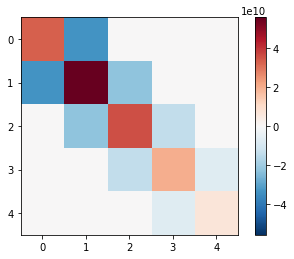

In [67]:
K = np.sum([L_e.T @ K_e @ L_e for L_e, K_e in zip(L_e_list, K_e_list)], axis=0)
print(K)

plt.imshow(K, cmap='RdBu_r', vmin=-np.max(np.abs(K)), vmax=np.max(np.abs(K)))
plt.colorbar()
plt.show()

Free and Essential Node Displacement --> Partioning

In [68]:
L = np.eye(n_nodes, dtype=int)
L_F = L[:,np.isnan(u)]
L_E = L[:,~np.isnan(u)]

print(L)
print(L_E)
print(L_F)

[[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]
[[1]
 [0]
 [0]
 [0]
 [0]]
[[0 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]


In [69]:
f_E = f[np.isnan(f)]
f_F = f[~np.isnan(f)]
u_E = u[~np.isnan(u)]
u_F = u[np.isnan(u)]

print("u = ")
print(u)
print(u_E)
print(u_F)

print("f = ")
print(f)
print(f_E)
print(f_F)

u = 
[ 0. nan nan nan nan]
[0.]
[nan nan nan nan]
f = 
[ nan   0.   0.   0. 100.]
[nan]
[  0.   0.   0. 100.]


In [70]:
K_EE = L_E.T @ K @ L_E
K_FE = L_F.T @ K @ L_E
K_EF = K_FE.T
K_FF = L_F.T @ K @ L_F

Solving for deflection and reaction force

In [71]:
u_F = np.linalg.inv(K_FF) @ (f_F - K_FE @ u_E)
f_E = K_EE @ u_E + K_EF @ u_F

u = L_E @ u_E + L_F @ u_F
f = L_E @ f_E + L_F @ f_F

print(u)
print(f)

[0.00000000e+00 2.99051578e-09 7.47627446e-09 1.48227090e-08
 2.94180786e-08]
[-100.    0.    0.    0.  100.]


Calculate stress

$\underline{\sigma}^{(e)} = \underline{\underline{C}} \, \underline{\underline{B}}^{(e)} \underline{\underline{L}}^{(e)} \underline{u}$

In [72]:
sigma = np.zeros(n_elements)
for idx, (element, B_e, L_e) in enumerate(zip(element_list, B_e_list, L_e_list)):
    x_m_e = np.mean(node_list[element])
    sigma[idx] = C @ B_e(x_m_e) @ L_e @ u

print(sigma)

[1196.20631014 1794.3034735  2938.5737976  5838.14786494]


Plot results

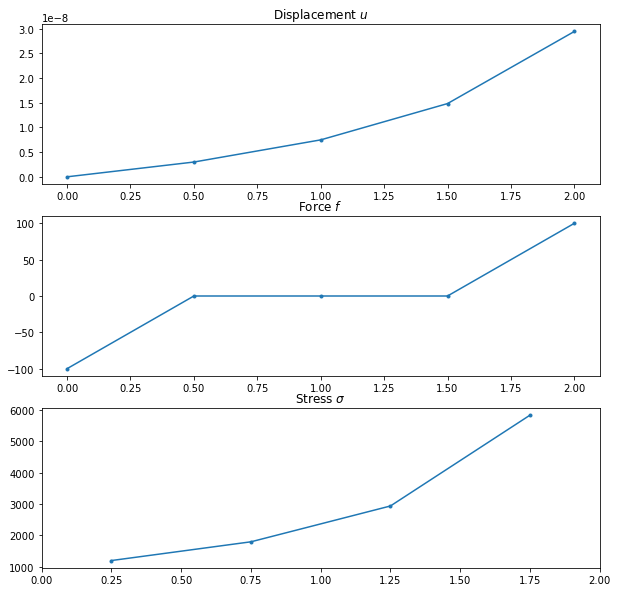

In [73]:
plot_1D_results(node_list, element_list, u, f, sigma)